# CS-6580 Lecture 8 - Augmenting Convolutional Neural Networks
**Dylan Zwick**

*Weber State University*

In our last lecture, we learned the basics of convolutional neural networks. Today, we're going to talk about some techniques that you can use to augment a convolutional neural network if you're in a situation where you don't have as much data as you'd like - a very common situation in real world applications! As a practical example, we'll work on classifying images as dogs or cats in a dataset containing images of cats and dogs. We'll use 2,000 images for training (a small set), 1,000 images for validation, and about 2,000 images for testing.

To get this data, you'll want to upload the cats_vs_dogs.zip file from Canvas into your working directory, and then (silently!) unzip it with the command:

In [ ]:
# !unzip -qq cats_vs_dogs.zip

This should create a folder "cats_vs_dogs" with subfolders of training, validation, and testing data.

And, as usual, we'll want to grab our standard libraries.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from keras import layers

### Building a basic model

First, we'll try to train a model from scratch using the little data we have - because you've got to start somewhere. We'll train a small convolutional neural network (covnet) to set the baseline for what can be achieved.

In [2]:
inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [3]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                        

In [4]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

We'll need to read the pictures in and transform them into appropriately preprocessed floating-point tensors before being fed into the model. Currently, we've got the data as JPEG files. So, the steps to getting them into the model are approximately:

* Read the picture files.
* Decode the JPEG content into RGB grids of pixels.
* Convert these into floating-point tensors.
* Resize them to a shared size (we'll use 180 x 180)
* Pack them into batches (we'll use batches of 32 images)

That might seem like a lot, but fortunately Keras has utilities to take care of these steps automatically. Specifically, it has a utility function *image_dataset_from_directory()*, which lets you quickly set up a data pipeline that can automatically turn image files on disk into batches of preprocessed tensors. This is what we'll use here.

Calling *image_dataset_from_directory(directory)* will first list the subdirectories of *directory* and assume each one contains images from one of our classes. It will then index the image files in each subdirectory. Finally, it will create and return a *tf.data.Datas.t* object configured to read these files, shuffle them, decode them to tensors, resize them to a shared size, and pack them into batches. Nice!

In [5]:
import os
import pathlib

from tensorflow.keras.utils import image_dataset_from_directory

In [7]:
base_dir = pathlib.Path("cats_vs_dogs")

train_dataset = image_dataset_from_directory(
    base_dir / "train",
    labels = 'inferred',
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    base_dir / "validation",
    labels = 'inferred',
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    base_dir / "test",
    labels = 'inferred',
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


Let's look at the output of one of these Dataset objects: it yields batches of $180 \times 180$ RGB images and integer labels. There are 32 samples in each batch (the batch size).

In [8]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


Alright, let's fit the model on our dataset.

We'll use a ModelCheckpoint callback to save the model after each epoch. We'll configure it with the path specifying where to save the file, as well as the arguments *save_best_only=True* and *monitor="val_loss"*: they tell the callback to only save a new file (overwriting any previous one) when the current value of the *val_loss* metric is lower than at any previous time during training. This way, if we start overfitting, we don't need to start training our model over again from scratch.

Alright, let's do some training! This may take a while.

In [10]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 24s 378ms/step - loss: 0.6876 - accuracy: 0.5735 - val_loss: 0.7071 - val_accuracy: 0.5050
Epoch 2/30
63/63 [==============================] - 24s 382ms/step - loss: 0.6565 - accuracy: 0.6170 - val_loss: 0.7853 - val_accuracy: 0.5370
Epoch 3/30
63/63 [==============================] - 25s 401ms/step - loss: 0.6155 - accuracy: 0.6645 - val_loss: 0.5814 - val_accuracy: 0.6840
Epoch 4/30
63/63 [==============================] - 25s 389ms/step - loss: 0.5886 - accuracy: 0.6870 - val_loss: 0.6078 - val_accuracy: 0.6670
Epoch 5/30
63/63 [==============================] - 26s 411ms/step - loss: 0.5475 - accuracy: 0.7235 - val_loss: 0.5810 - val_accuracy: 0.6830
Epoch 6/30
63/63 [==============================] - 26s 416ms/step - loss: 0.5100 - accuracy: 0.7440 - val_loss: 0.6687 - val_accuracy: 0.6570
Epoch 7/30
63/63 [==============================] - 26s 405ms/step - loss: 0.4900 - accuracy: 0.7645 - val_loss: 0.5084 - val_accuracy: 0.7490

We can plot the loss and accuracy of the model over the training and validation data for each epoch:

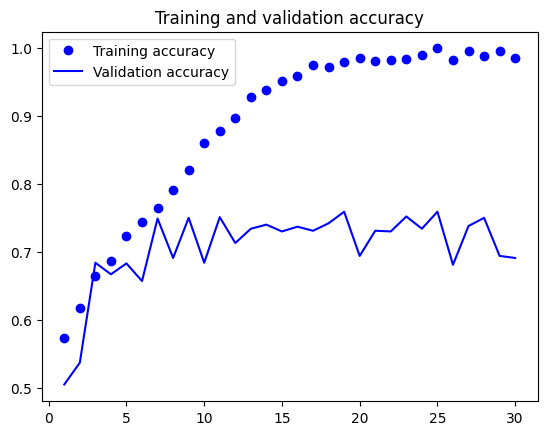

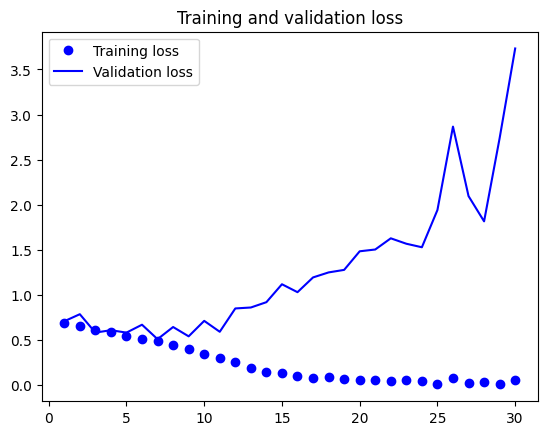

In [11]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

It looks like we start overfitting pretty soon - after about 9 epochs. Which isn't surprising given our small dataset.

Now let's reload our best model and try it out on our test dataset.

In [12]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 10s 156ms/step - loss: 0.5542 - accuracy: 0.7410
Test accuracy: 0.741


That's OK. Not great, but OK. Given how few training samples we have, overfitting will be our number one concern. How can we avoid it? Well, get more data!

However, this isn't always easy, so we'll introduce another method, specific to computer vision - data augmentation.

### Data Augmentation

Data augmentation generates more training data from existing training samples by *augmenting* the samples via a number of random transformations that yield believable-looking images.

In Keras, this can be done by adding a number of *data augmentation layers* at the start of the model. For example:

In [13]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

These are just a few of the layers available (for more, see the [Keras documentation](https://www.tensorflow.org/tutorials/images/data_augmentation)). What our transformations do is:

* Applies horizontal flipping to a random 50% of the images.
* Rotates the input images by a random value in the range of [-10%,+10%]
* Zooms in or out of the image by a random factor in the range [-20%,+20%]

For example:

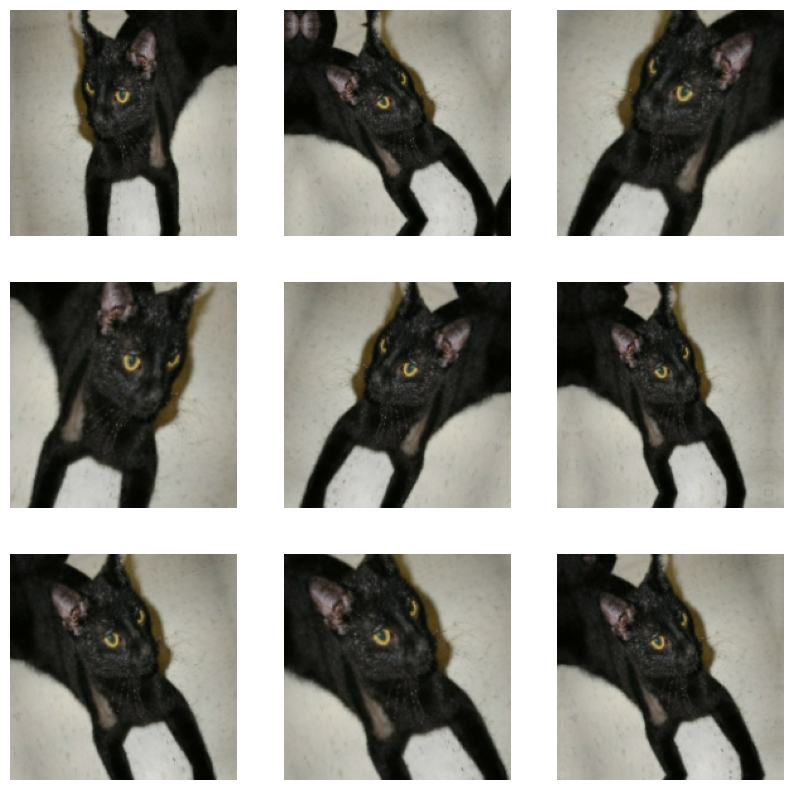

In [14]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

If we train our model using the data-augmentation configuration, the model will never see the same input twice. But, the inputs it sees are still heavily intercorrelated because they come from a small number of original images. As such, this technique won't completely get rid of overfitting.

Note the random image augmentation layers are inactive during inference.

In [15]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [16]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=60,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/60
63/63 [==============================] - 33s 506ms/step - loss: 0.7068 - accuracy: 0.4930 - val_loss: 0.6927 - val_accuracy: 0.5570
Epoch 2/60
63/63 [==============================] - 32s 502ms/step - loss: 0.6962 - accuracy: 0.5090 - val_loss: 0.6922 - val_accuracy: 0.5000
Epoch 3/60
63/63 [==============================] - 32s 501ms/step - loss: 0.6953 - accuracy: 0.5075 - val_loss: 0.6907 - val_accuracy: 0.5010
Epoch 4/60
63/63 [==============================] - 31s 496ms/step - loss: 0.6896 - accuracy: 0.5435 - val_loss: 0.6824 - val_accuracy: 0.5330
Epoch 5/60
63/63 [==============================] - 31s 498ms/step - loss: 0.6769 - accuracy: 0.5955 - val_loss: 0.7751 - val_accuracy: 0.5150
Epoch 6/60
63/63 [==============================] - 32s 502ms/step - loss: 0.6650 - accuracy: 0.6060 - val_loss: 0.6576 - val_accuracy: 0.6160
Epoch 7/60
63/63 [==============================] - 32s 507ms/step - loss: 0.6439 - accuracy: 0.6325 - val_loss: 0.6459 - val_accuracy: 0.6210

Epoch 58/60
63/63 [==============================] - 33s 522ms/step - loss: 0.2371 - accuracy: 0.9060 - val_loss: 0.5913 - val_accuracy: 0.8330
Epoch 59/60
63/63 [==============================] - 34s 537ms/step - loss: 0.2563 - accuracy: 0.8990 - val_loss: 0.5514 - val_accuracy: 0.7980
Epoch 60/60
63/63 [==============================] - 34s 534ms/step - loss: 0.2384 - accuracy: 0.9110 - val_loss: 0.5874 - val_accuracy: 0.8270


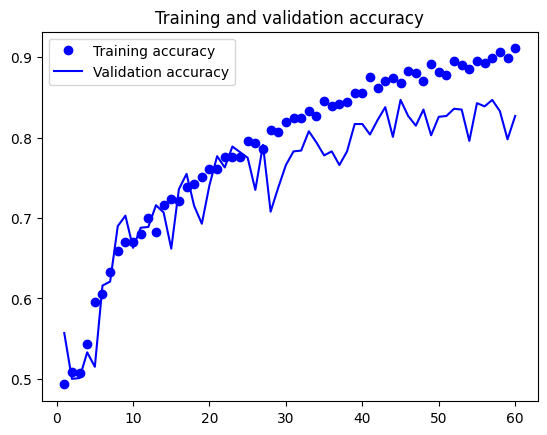

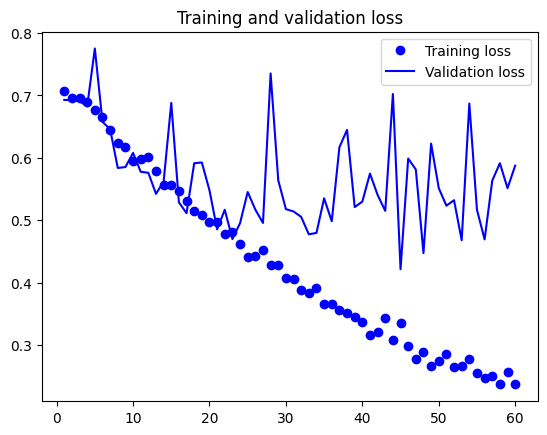

In [17]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
test_model = keras.models.load_model("convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

### Levaging a pretrained model

A common and highly effective approach to deep learning on small image datasets is to use a pretrained model. A *pretrained model* is a model that was previously trained on a large dataset, typically on a large-scale image classification task. If this original dataset is large enough and general enough, the hierarchy of features learned by the pretrained model can effectively act as a generic model of the visual world, and prove useful for many different computer vision problems, even though these new problems may involve completely different classes than those of the original task.

For instance, you might train a model on ImageNet (where classes are mostly animals and everyday objects) and then repurpose this trained model for something like identifying furniture items in images. Such portability of learned features across different problems is a key advantage of deep learning.

For our case, we'll use a large convnet trained on the ImageNet dataset (1.4 million labeled images and 1,000 different classes). ImageNet contains many animal classes, including different species of cats and  dogs, and you can thus expect it to perform well on the dogs-versus-cats classification problem.

There are two ways to use a pretrained model: *feature extraction* and *fine tuning*. We'll start with feature extraction.

#### Feature extraction

Feature extraction consists of using the representations learned by a previously trained model to extract interesting features from new samples. These features are then run through a new classifier, which is trained from scratch.

Most convnets are made of two parts: first, a series of convolution and pooling layers, and then a densely connected classifier. The first part is called the *convolutional base* of the model. Feature extraction consists of taking the convolutional base of a previously trained network, running the new data through it, and training a new classifier on top of the output.

Why only reuse the convolutional base? Could we reuse the densely connected classifier as well? In general, doing so should be avoided. The reason is that the representations learned by the convolutional base are likely to be more generic and, therefore, more reusable: the feature maps of a convnet are presence maps of generic concepts over a picture, which are likely to be useful regardless of the computer vision problem at hand. But the representations learned by the classifier will necessarily be specific to the set of classes on which the model was trained—they will only contain information about the presence probability of this or that class in the entire picture. Additionally, representations found in densely connected layers no longer contain any information about where objects are located in the input image; these layers get rid of the notion of space, whereas the object location is still described by convolutional feature maps. For problems where object location matters, densely connected features are largely useless. 

Note that the level of generality (and therefore reusability) of the representations extracted by specific convolution layers depends on the depth of the layer in the model. Layers that come earlier in the model extract local, highly generic feature maps (such as visual edges, colors, and textures), whereas layers that are higher up extract more-abstract concepts (such as “cat ear” or “dog eye”). So if your new dataset differs a lot from the dataset on which the original model was trained, you may be better off using only the first few layers of the model to do feature extraction, rather than using the entire convolutional base. 

In this case, because the ImageNet class set contains multiple dog and cat classes, it’s likely to be beneficial to reuse the information contained in the densely connected layers of the original model. But we’ll choose not to, in order to cover the more general case where the class set of the new problem doesn’t overlap the class set of the original model. Let’s put this into practice by using the convolutional base of the VGG16 network, trained on ImageNet, to extract interesting features from cat and dog images, and then train a dogs-versus-cats classifier on top of these features. The VGG16 model, among others, comes prepackaged with Keras. You can import it from the keras.applications module.

In [19]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

58889256/58889256 [==============================] - 7s 0us/step


We pass three arguments to the constructor: 

* weights specifies the weight checkpoint from which to initialize the model. 
* *include_top* refers to including (or not) the densely connected classifier on top of the network. By default, this densely connected classifier corresponds to the 1,000 classes from ImageNet. Because we intend to use our own densely connected classifier (with only two classes: cat and dog), we don’t need to include it. 
* *input_shape* is the shape of the image tensors that we’ll feed to the network. This argument is purely optional: if we don’t pass it, the network will be able to process inputs of any size. Here we pass it so that we can visualize (in the following summary) how the size of the feature maps shrinks with each new convolution and pooling layer. 

Here’s the detail of the architecture of the VGG16 convolutional base. It’s similar to the simple convnets you’re already familiar with:

In [20]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

The final feature map has shape (5, 5, 512). That’s the feature map on top of which we’ll stick a densely connected classifier. 

At this point, there are two ways we could proceed: 

* Run the convolutional base over our dataset, record its output to a NumPy array on disk, and then use this data as input to a standalone, densely connected classifier. This solution is fast and cheap to run, because it only requires running the convolutional base once for every input image, and the convolutional base is by far the most expensive part of the pipeline. But for the same reason, this technique won’t allow us to use data augmentation. 

* Extend the model we have (conv_base) by adding Dense layers on top, and run the whole thing from end to end on the input data. This will allow us to use data augmentation, because every input image goes through the convolutional base every time it’s seen by the model. But for the same reason, this technique is far more expensive than the first.

Well do the first - not because it's better, but just because it's faster.

In [21]:
def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 [==============================] - 1s 1s/step


Importantly, *predict()* only expects images, not labels, but our current dataset yields batches that contain both images and their labels. Moreover, the VGG16 model expects inputs that are preprocessed with the function keras.applications.vgg16.preprocess_input, which scales pixel values to an appropriate range. 

The extracted features are currently of shape (samples, 5, 5, 512):

In [22]:
train_features.shape

(2000, 5, 5, 512)

At this point, we can define our densely connected classifier and train it on the data and labels that we just recorded.

In [23]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
63/63 [==============================] - 2s 19ms/step - loss: 15.4818 - accuracy: 0.9250 - val_loss: 3.3182 - val_accuracy: 0.9720
Epoch 2/20
63/63 [==============================] - 1s 13ms/step - loss: 3.5221 - accuracy: 0.9715 - val_loss: 5.3062 - val_accuracy: 0.9660
Epoch 3/20
63/63 [==============================] - 1s 16ms/step - loss: 2.4628 - accuracy: 0.9840 - val_loss: 5.0940 - val_accuracy: 0.9710
Epoch 4/20
63/63 [==============================] - 1s 15ms/step - loss: 0.9338 - accuracy: 0.9900 - val_loss: 4.3449 - val_accuracy: 0.9760
Epoch 5/20
63/63 [==============================] - 1s 16ms/step - loss: 0.8614 - accuracy: 0.9935 - val_loss: 4.5035 - val_accuracy: 0.9660
Epoch 6/20
63/63 [==============================] - 1s 13ms/step - loss: 0.4147 - accuracy: 0.9960 - val_loss: 4.7150 - val_accuracy: 0.9770
Epoch 7/20
63/63 [==============================] - 1s 15ms/step - loss: 0.8375 - accuracy: 0.9930 - val_loss: 11.2567 - val_accuracy: 0.9520
Epoch 8/20


Training is very fast because we only have to deal with two Dense layers—an epoch takes less than one second even on CPU. 

Let’s look at the loss and accuracy curves during training.

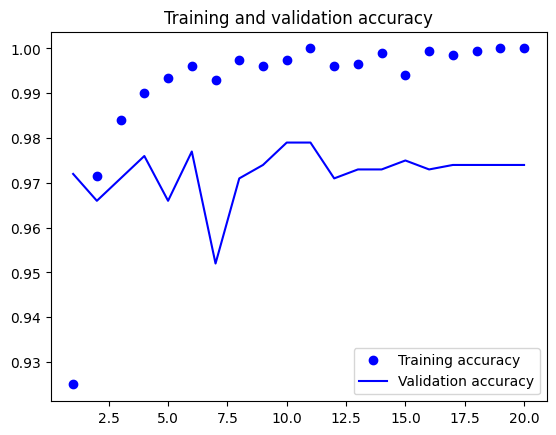

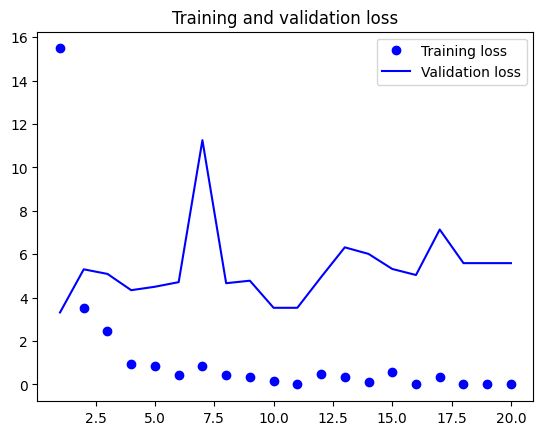

In [24]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

We reach a validation accuracy of about 97%—much better than we achieved in the previous section with the small model trained from scratch. This is a bit of an unfair comparison, however, because ImageNet contains many dog and cat instances, which means that our pretrained model already has the exact knowledge required for the task at hand. This won’t always be the case when you use pretrained features. 

However, the plots also indicate that we’re overfitting almost from the start— despite using dropout with a fairly large rate. That’s because this technique doesn’t use data augmentation, which is essential for preventing overfitting with small image datasets.

#### Fine-tuning a pretrained model

Another widely used technique for model reuse, complementary to feature extraction, is fine-tuning. Fine-tuning consists of unfreezing a few of the top layers of a frozen model base used for feature extraction, and jointly training both the newly added part of the model (in this case, the fully connected classifier) and these top layers. This is called fine-tuning because it slightly adjusts the more abstract representations of the model being reused in order to make them more relevant for the problem at hand. 

I stated earlier that it’s necessary to freeze the convolution base of VGG16 in order to be able to train a randomly initialized classifier on top. For the same reason, it’s only possible to fine-tune the top layers of the convolutional base once the classifier on top has already been trained. If the classifier isn’t already trained, the error signal propagating through the network during training will be too large, and the representations previously learned by the layers being fine-tuned will be destroyed. Thus the steps for fine-tuning a network are as follows: 

1. Add our custom network on top of an already-trained base network. 
2. Freeze the base network. 
3. Train the part we added. 
4. Unfreeze some layers in the base network. (Note that you should not unfreeze “batch normalization” layers, which are not relevant here since there are no such layers in VGG16. Batch normalization and its impact on finetuning is explained in the next chapter.) 
5. Jointly train both these layers and the part we added. 

In [25]:
inputs = keras.Input(shape=(180, 180, 3))
# x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(inputs)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [26]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

We’ll fine-tune the last three convolutional layers, which means all layers up to *block4_ pool* should be frozen, and the layers *block5_conv1*, *block5_conv2*, and *block5_conv3* should be trainable.

Why not fine-tune more layers? Why not fine-tune the entire convolutional base? You could. But you need to consider the following: 

* Earlier layers in the convolutional base encode more generic, reusable features, whereas layers higher up encode more specialized features. It’s more useful to fine-tune the more specialized features, because these are the ones that need to be repurposed on your new problem. There would be fast-decreasing returns in fine-tuning lower layers. 
* The more parameters you’re training, the more you’re at risk of overfitting. The convolutional base has 15 million parameters, so it would be risky to attempt to train it on your small dataset. 

Thus, in this situation, it’s a good strategy to fine-tune only the top two or three layers in the convolutional base. Let’s set this up.

In [27]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

Now we can begin fine-tuning the model. We’ll do this with the RMSprop optimizer, using a very low learning rate. The reason for using a low learning rate is that we want to limit the magnitude of the modifications we make to the representations of the three layers we’re fine-tuning. Updates that are too large may harm these representations.

In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
32/63 [==============>...............] - ETA: 4:44 - loss: 3.3872 - accuracy: 0.7354

We can finally evaluate this model on the test data:

In [ ]:
model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

Alright!